# İş Problemi
Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin
edebilecek bir makine öğrenmesi modeli geliştirilmesi istenmektedir. Modeli
geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını
gerçekleştirmeniz beklenmektedir.

# Veri Seti Hikayesi
Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır. ABD'deki
Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları üzerinde
yapılan diyabet araştırması için kullanılan verilerdir.
Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

Pregnancies Hamilelik sayısı

Glucose Oral glikoz tolerans testinde 2 saatlik plazma glikoz konsantrasyonu

Blood Pressure Kan Basıncı (Küçük tansiyon) (mm Hg)

SkinThickness Cilt Kalınlığı

Insulin 2 saatlik serum insülini (mu U/ml)

DiabetesPedigreeFunction Soydaki kişilere göre diyabet olma ihtimalini hesaplayan bir fonksiyon

BMI Vücut kitle endeksi

Age Yaş (yıl)

Outcome Hastalığa sahip (1) ya da değil (0)


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier

pd.set_option('expand_frame_repr', True)
pd.set_option("display.max_rows", 999)
pd.set_option('max_colwidth',100)


**Görev 1 : Keşifçi Veri Analizi**
Adım 1: Genel resmi inceleyiniz.

In [4]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
def checkDf(dataframe, head = 8):
  print("##### Shape #####")
  print(dataframe.shape)
  print("\n##### Types #####")
  print(dataframe.dtypes)
  print("\n##### Tail #####")
  print(dataframe.tail(head))
  print("\n##### Head #####")
  print(dataframe.head(head))
  print("\n##### Null Analysis #####")
  print(dataframe.isnull().sum())
  print("\n##### Quantiles #####")
  print(dataframe.describe([0,0.05, 0.50, 0.95, 0.99, 1]).T)    

In [6]:
checkDf(df)

##### Shape #####
(768, 9)

##### Types #####
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

##### Tail #####
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
760            2       88             58             26       16  28.4   
761            9      170             74             31        0  44.0   
762            9       89             62              0        0  22.5   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767   

In [7]:
df.columns = [col.upper() for col in df.columns]

Adım 2: Numerik ve kategorik değişkenleri yakalayınız.

In [8]:
def grabColNames(dataframe, catTh=10, carTh=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        catTh: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        carTh: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        catCols: list
                Kategorik değişken listesi
        numCols: list
                Numerik değişken listesi
        catButCar: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grabColNames(df))


    Notes
    ------
        catCols + numCols + catButCar = toplam değişken sayısı
        numButCat catCols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: catCols + numCols + catButCar = değişken sayısı

    """

    # catCols, catButCar
    catCols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    numButCat = [col for col in dataframe.columns if dataframe[col].nunique() < catTh and
                 dataframe[col].dtypes != "O"]
    catButCar = [col for col in dataframe.columns if dataframe[col].nunique() > carTh and
                 dataframe[col].dtypes == "O"]
    catCols = catCols + numButCat
    catCols = [col for col in catCols if col not in catButCar]

    # numCols
    numCols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    numCols = [col for col in numCols if col not in numButCat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'catCols: {len(catCols)}')
    print(f'numCols: {len(numCols)}')
    print(f'catButCar: {len(catButCar)}')
    print(f'numButCat: {len(numButCat)}')
    return catCols, numCols, catButCar


catCols, numCols, catButCar = grabColNames(df)


Observations: 768
Variables: 9
catCols: 1
numCols: 8
catButCar: 0
numButCat: 1


Adım 3: Numerik ve kategorik değişkenlerin analizini yapınız.

In [9]:
numCols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE']

PREGNANCIES:
count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
100%      17.000000
max       17.000000
Name: PREGNANCIES, dtype: float64


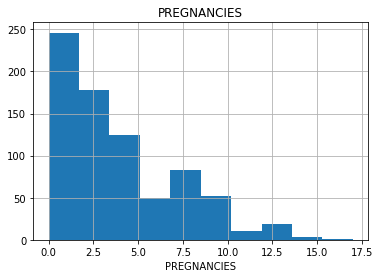

GLUCOSE:
count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
100%     199.000000
max      199.000000
Name: GLUCOSE, dtype: float64


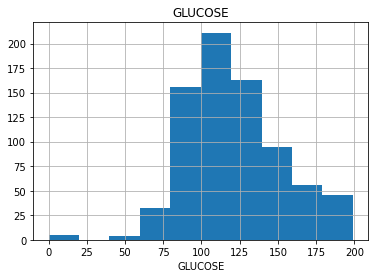

BLOODPRESSURE:
count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
100%     122.000000
max      122.000000
Name: BLOODPRESSURE, dtype: float64


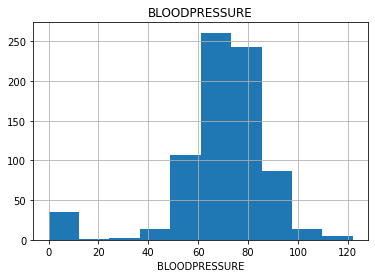

SKINTHICKNESS:
count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
100%      99.000000
max       99.000000
Name: SKINTHICKNESS, dtype: float64


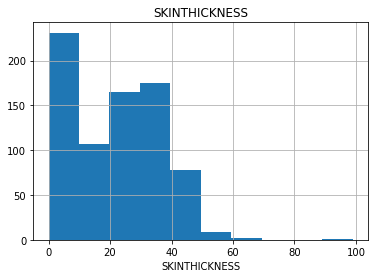

INSULIN:
count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
100%     846.000000
max      846.000000
Name: INSULIN, dtype: float64


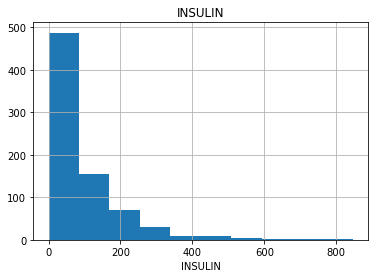

BMI:
count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
100%      67.100000
max       67.100000
Name: BMI, dtype: float64


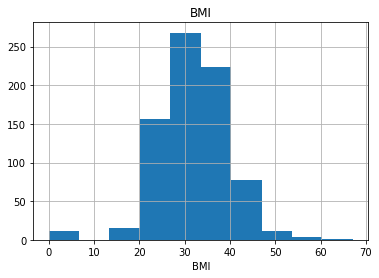

DIABETESPEDIGREEFUNCTION:
count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
100%       2.420000
max        2.420000
Name: DIABETESPEDIGREEFUNCTION, dtype: float64


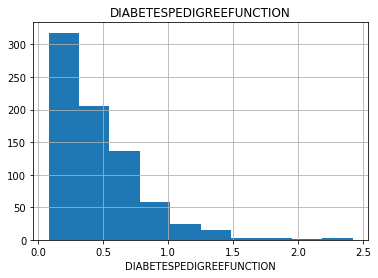

AGE:
count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
100%      81.000000
max       81.000000
Name: AGE, dtype: float64


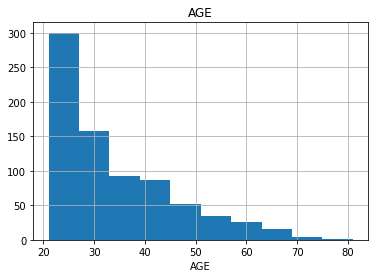

In [10]:
def numSummary(dataframe, numericalCol, plot=False):
    quantiles = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
    print(dataframe[numericalCol].describe(quantiles).T)
    
    if plot:
        dataframe[numericalCol].hist()
        plt.xlabel(numericalCol)
        plt.title(numericalCol)
        plt.show(block=True)

for col in numCols:
    print(f"{col}:")
    numSummary(df, col, True)

   OUTCOME      Ratio
0      500  65.104167
1      268  34.895833
##########################################


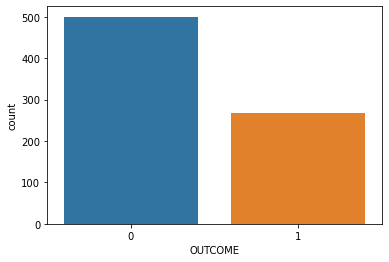

In [11]:
def catSummary(dataframe, colName, plot=False):
    print(pd.DataFrame({colName: dataframe[colName].value_counts(),
                        "Ratio": 100 * dataframe[colName].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[colName], data=dataframe)
        plt.show(block=True)
    
for col in catCols:
    if df[col].dtypes == "bool":
        print(col)
    else:
        catSummary(df, col, True)

Adım 4: Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre numerik değişkenlerin ortalaması)


In [12]:
def targetSummaryWithNum(dataframe, target, numCol):
    print(dataframe.groupby(target).agg({numCol: "mean"}), end="\n\n\n")
for col in numCols:
    targetSummaryWithNum(df, 'OUTCOME', col)

         PREGNANCIES
OUTCOME             
0           3.298000
1           4.865672


            GLUCOSE
OUTCOME            
0        109.980000
1        141.257463


         BLOODPRESSURE
OUTCOME               
0            68.184000
1            70.824627


         SKINTHICKNESS
OUTCOME               
0            19.664000
1            22.164179


            INSULIN
OUTCOME            
0         68.792000
1        100.335821


               BMI
OUTCOME           
0        30.304200
1        35.142537


         DIABETESPEDIGREEFUNCTION
OUTCOME                          
0                        0.429734
1                        0.550500


               AGE
OUTCOME           
0        31.190000
1        37.067164




Adım 5: Aykırı gözlem analizi yapınız.

In [13]:
def outlierThresholds(dataframe, colName, q1=0.25, q3=0.75):
    quartile1 = dataframe[colName].quantile(q1)
    quartile3 = dataframe[colName].quantile(q3)
    interquantileRange = quartile3 - quartile1
    upLimit = quartile3 + 1.5 * interquantileRange
    lowLimit = quartile1 - 1.5 * interquantileRange
    return lowLimit, upLimit

def checkOutlier(dataframe, colName):
    lowLimit, upLimit = outlierThresholds(dataframe, colName)
    if dataframe[(dataframe[colName] > upLimit) | (dataframe[colName] < lowLimit)].any(axis=None):
        return True
    else:
        return False

In [14]:
for col in numCols:
    print(col, "-->", checkOutlier(df, col))

PREGNANCIES --> True
GLUCOSE --> True
BLOODPRESSURE --> True
SKINTHICKNESS --> True
INSULIN --> True
BMI --> True
DIABETESPEDIGREEFUNCTION --> True
AGE --> True


In [15]:
def grabOutliers(dataframe, colName, index=False):
    low, up = outlierThresholds(dataframe, colName)

    if dataframe[((dataframe[colName] < low) | (dataframe[colName] > up))].shape[0] > 10:
        print(display(dataframe[((dataframe[colName] < low) | (dataframe[colName] > up))].head()))
    else:
        print((dataframe[((dataframe[colName] < low) | (dataframe[colName] > up))]))

    if index:
        outlier_index = dataframe[((dataframe[colName] < low) | (dataframe[colName] > up))].index
        return outlier_index
for col in numCols:
    print(col, grabOutliers(df, col, True))

     PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  \
88            15      136             70             32      110  37.1   
159           17      163             72             41      114  40.9   
298           14      100             78             25      184  36.6   
455           14      175             62             30        0  33.6   

     DIABETESPEDIGREEFUNCTION  AGE  OUTCOME  
88                      0.153   43        1  
159                     0.817   47        1  
298                     0.412   46        1  
455                     0.212   38        1  
PREGNANCIES Int64Index([88, 159, 298, 455], dtype='int64')
     PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  \
75             1        0             48             20        0  24.7   
182            1        0             74             20       23  27.7   
342            1        0             68             35        0  32.0   
349            5        0             80    

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
7,10,115,0,0,0,35.3,0.134,29,0
15,7,100,0,0,0,30.0,0.484,32,1
18,1,103,30,38,83,43.3,0.183,33,0
43,9,171,110,24,240,45.4,0.721,54,1
49,7,105,0,0,0,0.0,0.305,24,0


None
BLOODPRESSURE Int64Index([  7,  15,  18,  43,  49,  60,  78,  81,  84, 106, 125, 172, 177,
            193, 222, 261, 266, 269, 300, 332, 336, 347, 357, 362, 426, 430,
            435, 453, 468, 484, 494, 522, 533, 535, 549, 589, 597, 601, 604,
            619, 643, 691, 697, 703, 706],
           dtype='int64')
     PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  \
579            2      197             70             99        0  34.7   

     DIABETESPEDIGREEFUNCTION  AGE  OUTCOME  
579                     0.575   62        1  
SKINTHICKNESS Int64Index([579], dtype='int64')


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
54,7,150,66,42,342,34.7,0.718,42,0
111,8,155,62,26,495,34.0,0.543,46,1
139,5,105,72,29,325,36.9,0.159,28,0


None
INSULIN Int64Index([  8,  13,  54, 111, 139, 153, 186, 220, 228, 231, 247, 248, 258,
            286, 296, 360, 370, 375, 392, 409, 415, 480, 486, 519, 574, 584,
            612, 645, 655, 695, 707, 710, 715, 753],
           dtype='int64')


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
120,0,162,76,56,100,53.2,0.759,25,1


None
BMI Int64Index([  9,  49,  60,  81, 120, 125, 145, 177, 193, 247, 303, 371, 426,
            445, 494, 522, 673, 684, 706],
           dtype='int64')


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
4,0,137,40,35,168,43.1,2.288,33,1
12,10,139,80,0,0,27.1,1.441,57,0
39,4,111,72,47,207,37.1,1.390,56,1
45,0,180,66,39,0,42.0,1.893,25,1
58,0,146,82,0,0,40.5,1.781,44,0


None
DIABETESPEDIGREEFUNCTION Int64Index([  4,  12,  39,  45,  58, 100, 147, 187, 218, 228, 243, 245, 259,
            292, 308, 330, 370, 371, 383, 395, 445, 534, 593, 606, 618, 621,
            622, 659, 661],
           dtype='int64')
     PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  \
123            5      132             80              0        0  26.8   
363            4      146             78              0        0  38.5   
453            2      119              0              0        0  19.6   
459            9      134             74             33       60  25.9   
489            8      194             80              0        0  26.1   
537            0       57             60              0        0  21.7   
666            4      145             82             18        0  32.5   
674            8       91             82              0        0  35.6   
684            5      136             82              0        0   0.0   

     DIABETESPEDIGREE

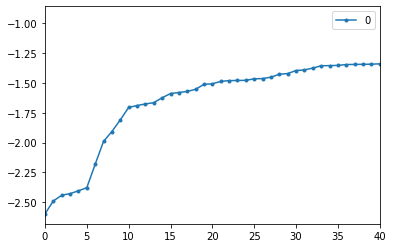

In [16]:
clf = LocalOutlierFactor(n_neighbors=20) 
clf.fit_predict(df)
dfScores = clf.negative_outlier_factor_
scores = pd.DataFrame(np.sort(dfScores))
scores.plot(stacked=True, xlim=[0, 40], style=".-")
plt.show()

Adım 6: Eksik gözlem analizi yapınız.

In [17]:
def missingValuesTable(dataframe,naName = False):
    naColums = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    nMiss = dataframe[naColums].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[naColums].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missingDf = pd.concat([nMiss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missingDf,end='\n')
    if naName:
        return naColums
missingValuesTable(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []



Adım 7: Korelasyon analizi yapınız

In [18]:
corr = df[numCols].corr()
corr

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE
PREGNANCIES,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341
GLUCOSE,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514
BLOODPRESSURE,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528
SKINTHICKNESS,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970
INSULIN,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242
DIABETESPEDIGREEFUNCTION,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561
AGE,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000


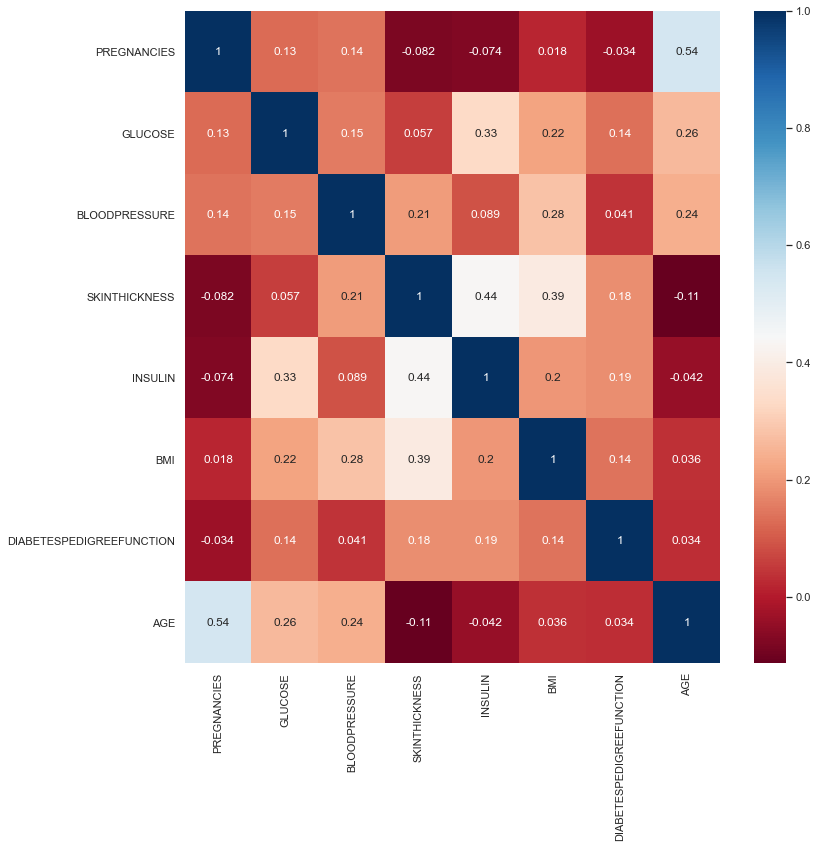

In [19]:
sns.set(rc={"figure.figsize": (12, 12)})
sns.heatmap(corr, cmap="RdBu", annot=True) 
plt.show()

**Görev 2** 

Adım 1: Eksik ve aykırı değerler için gerekli işlemleri yapınız. Veri setinde eksik gözlem bulunmamakta ama Glikoz, Insulin vb. değişkenlerde 0 değeri içeren gözlem birimleri eksik değeri ifade ediyor olabilir. Örneğin; bir kişinin glikoz veya insulin değeri 0 olamayacaktır. Bu durumu dikkate alarak sıfır değerlerini ilgili değerlerde NaN olarak atama yapıp sonrasında eksik
değerlere işlemleri uygulayabilirsiniz.


In [20]:
df.skew(skipna=True)

PREGNANCIES                 0.901674
GLUCOSE                     0.173754
BLOODPRESSURE              -1.843608
SKINTHICKNESS               0.109372
INSULIN                     2.272251
BMI                        -0.428982
DIABETESPEDIGREEFUNCTION    1.919911
AGE                         1.129597
OUTCOME                     0.635017
dtype: float64

In [21]:
df = df.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)
df.isnull().sum()

PREGNANCIES                 0
GLUCOSE                     0
BLOODPRESSURE               0
SKINTHICKNESS               0
INSULIN                     0
BMI                         0
DIABETESPEDIGREEFUNCTION    0
AGE                         0
OUTCOME                     0
dtype: int64

In [22]:
def missingVsTarget(dataframe, target, naColumns):
    tempDf = dataframe.copy()
    for col in naColumns:
        tempDf[col + '_NA_FLAG'] = np.where(tempDf[col].isnull(), 1, 0)
    naFlags = tempDf.loc[:, tempDf.columns.str.contains('_NA_')].columns
    for col in naFlags:
        print(pd.DataFrame({'TARGET_MEAN': tempDf.groupby(col)[target].mean(),
                            'Count': tempDf.groupby(col)[target].count()}), end='\n\n\n')

In [47]:
zeroToNanCols = ['GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI']
for col in zeroToNanCols:
    df[col] = df[col].replace({'0':np.nan, 0:np.nan})
    
missingValuesTable(df)

               n_miss  ratio
INSULIN           374  48.70
SKINTHICKNESS     227  29.56
BLOODPRESSURE      35   4.56
BMI                11   1.43
GLUCOSE             5   0.65


In [48]:
missingVsTarget(df, 'OUTCOME', zeroToNanCols)

                 TARGET_MEAN  Count
GLUCOSE_NA_FLAG                    
0                   0.348624    763
1                   0.400000      5


                       TARGET_MEAN  Count
BLOODPRESSURE_NA_FLAG                    
0                         0.343793    733
1                         0.457143     35


                       TARGET_MEAN  Count
SKINTHICKNESS_NA_FLAG                    
0                         0.332717    541
1                         0.387665    227


                 TARGET_MEAN  Count
INSULIN_NA_FLAG                    
0                   0.329949    394
1                   0.368984    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0               0.351387    757
1               0.181818     11




In [ ]:
def replaceWithThresholds(dataframe, colName):
    low, up = outlierThresholds(dataframe, colName)

    dataframe.loc[dataframe[colName] > up, colName] = up
    dataframe.loc[dataframe[colName] < low, colName] = low
    
for col in numCols:
    replaceWithThresholds(df, col)
for col in numCols:
    print(col, checkOutlier(df, col))

In [ ]:
df["INSULIN"].fillna(df["INSULIN"].mean(), inplace=True)
df["SKINTHICKNESS"].fillna(df["SKINTHICKNESS"].mean(), inplace=True)
df["BMI"].fillna(df["BMI"].mean(), inplace=True)
df["BLOODPRESSURE"].fillna(df["BLOODPRESSURE"].mean(), inplace=True)
df["GLUCOSE"].fillna(df["GLUCOSE"].mean(), inplace=True)



In [ ]:
clf = LocalOutlierFactor(n_neighbors=20) 

In [ ]:
clf.fit_predict(df)

In [ ]:
df_scores = clf.negative_outlier_factor_
sorted_df_scores = np.sort(df_scores)
scores = pd.DataFrame(sorted_df_scores)
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.show()

In [ ]:
th = sorted_df_scores[7]
th

In [ ]:
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

In [ ]:
df.drop(axis=0, labels=df[df_scores < th].index, inplace=True)


Adım 2: Yeni değişkenler oluşturunuz.

In [ ]:
numCols

In [ ]:
df.loc[(df['AGE'] >= 21) & (df['AGE'] < 35),'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 35) & (df['AGE'] < 55), 'NEW_AGE_CAT'] = 'mature'


df.groupby("NEW_AGE_CAT").agg({"OUTCOME":["count", "mean"]})

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

testStat, pvalue = proportions_ztest(count =[df.loc[df['NEW_AGE_CAT'] == "young", "OUTCOME"].sum(),
                                             df.loc[df['NEW_AGE_CAT'] == "mature", "OUTCOME"].sum()],
                                      
                                      nobs = [df.loc[df['NEW_AGE_CAT'] == "young", "OUTCOME"].shape[0],
                                              df.loc[df['NEW_AGE_CAT'] == "mature", "OUTCOME"].shape[0]])

print("Test Stat = %.4f, p-value = %.4f" % (testStat, pvalue))

In [ ]:
df.loc[(df['BMI'] > df["BMI"].min()) & (df['BMI'] < 30), 'BMI_CLASS'] = 'ideal'
df.loc[(df['BMI'] > 30), "BMI_CLASS"] = 'overweight'

df.groupby("BMI_CLASS").agg({"OUTCOME":["count", "mean"]})

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

test_stat, pvalue = proportions_ztest(count =[df.loc[df['BMI_CLASS'] == "ideal", "OUTCOME"].sum(),
                                             df.loc[df['BMI_CLASS'] == "overweight", "OUTCOME"].sum()],
                                      
                                      nobs = [df.loc[df['BMI_CLASS'] == "ideal", "OUTCOME"].shape[0],
                                              df.loc[df['BMI_CLASS'] == "overweight", "OUTCOME"].shape[0]])

print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Adım 3: Encoding işlemlerini gerçekleştiriniz.


In [ ]:
def labelEncoder(dataframe, binaryCol):
    labelencoder = LabelEncoder()
    dataframe[binaryCol] = labelencoder.fit_transform(dataframe[binaryCol])
    return dataframe

In [ ]:
binaryCols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]
binaryCols

In [ ]:
for col in binaryCols:
    labelEncoder(df, col)
df.head()

In [ ]:
def rareAnalyzer(dataframe, target, catCols):
    for col in  catCols:
        print(col,":",len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),"RATIO": dataframe[col].value_counts() / len(dataframe),"TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [ ]:
rareAnalyzer(df, 'OUTCOME', binaryCols)

In [ ]:
def rareEncoder(dataframe, rarePerc):
    tempDf = dataframe.copy()
    rare_columns = [col for col in tempDf.columns if tempDf[col].dtypes == "O" and (tempDf[col].value_counts() / len(tempDf) < rarePerc).any(axis = None)]
    for var in rare_columns:
        tmp = tempDf[var].value_counts() / len(tempDf)
        rareLabels = tmp[tmp < rarePerc].index
        tempDf[var] = np.where(tempDf[var].isin(rareLabels), "Rare", tempDf[var])
    return tempDf

In [ ]:
newDf = rareEncoder(df, 0.01)

In [ ]:
def oneHotEncoder(dataframe, categoricalCols, drop_first = False):
    dataframe = pd.get_dummies(dataframe, columns=categoricalCols,drop_first=drop_first)
    return dataframe
oheCols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
oheCols

In [ ]:
df = oneHotEncoder(df, oheCols)
df.head()

Adım 4: Numerik değişkenler için standartlaştırma yapınız.


In [ ]:
scaler = StandardScaler()
df[numCols] = scaler.fit_transform(df[numCols])
df[numCols].head()

In [ ]:
df.columns

Adım 5: Model oluşturunuz.

In [ ]:
y = df["OUTCOME"]
X = df.drop('OUTCOME', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=10, random_state=1, shuffle=True)

y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)

model = RandomForestClassifier()
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores.mean()

In [ ]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importance.png")
plot_importance(rf_model, X_train)

In [73]:
clf.fit_predict(df)

array([ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

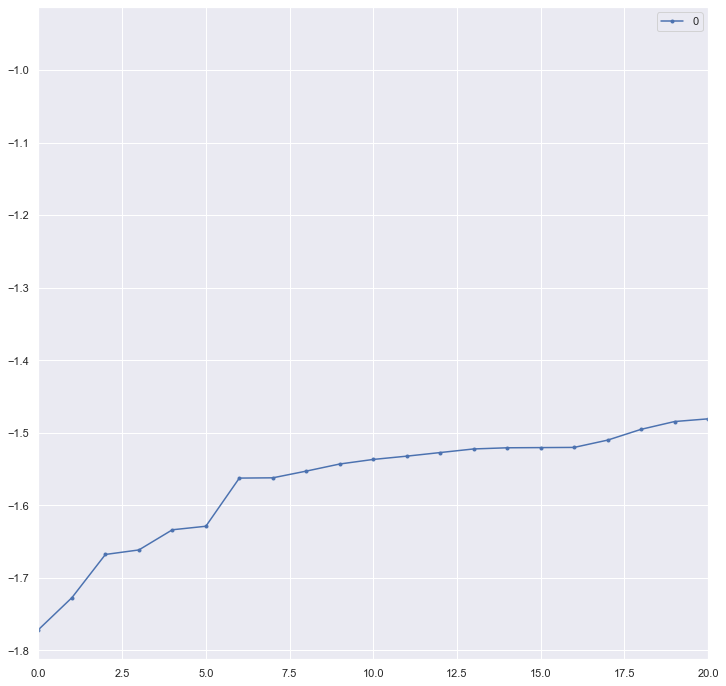

In [74]:
df_scores = clf.negative_outlier_factor_
sorted_df_scores = np.sort(df_scores)
scores = pd.DataFrame(sorted_df_scores)
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.show()

In [75]:
th = sorted_df_scores[7]
th

-1.5620245701159197

In [76]:
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
index,768.0,383.500000,221.846794,0.000,7.67000,38.35000,383.500000,575.25000,690.3000,759.3300,767.000
PREGNANCIES,768.0,3.837240,3.344157,0.000,0.00000,0.00000,3.000000,6.00000,9.0000,13.0000,13.500
GLUCOSE,768.0,121.686763,30.435949,44.000,67.67000,80.00000,117.000000,140.25000,167.0000,196.0000,199.000
BLOODPRESSURE,768.0,72.375171,11.696835,40.000,44.00000,52.00000,72.187585,80.00000,88.0000,104.0000,104.000
SKINTHICKNESS,768.0,29.059150,8.438759,7.000,10.00000,14.35000,29.059150,32.00000,40.0000,51.3300,57.000
INSULIN,768.0,146.500000,64.672728,14.000,24.34000,50.00000,146.500000,146.50000,210.0000,360.6250,360.625
BMI,768.0,32.394716,6.667462,18.200,19.50000,22.23500,32.394716,36.60000,41.5000,50.0825,50.250
DIABETESPEDIGREEFUNCTION,768.0,0.458914,0.285596,0.078,0.09468,0.14035,0.372500,0.62625,0.8786,1.2000,1.200
AGE,768.0,33.199870,11.628404,21.000,21.00000,21.00000,29.000000,41.00000,51.0000,66.5000,66.500
OUTCOME,768.0,0.348958,0.476951,0.000,0.00000,0.00000,0.000000,1.00000,1.0000,1.0000,1.000


In [77]:
df.drop(axis=0, labels=df[df_scores < th].index, inplace=True)


Adım 2: Yeni değişkenler oluşturunuz.

In [81]:
numCols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE']

In [82]:
df.loc[(df['AGE'] >= 21) & (df['AGE'] < 35),'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 35) & (df['AGE'] < 55), 'NEW_AGE_CAT'] = 'mature'


df.groupby("NEW_AGE_CAT").agg({"OUTCOME":["count", "mean"]})

OUTCOME          
              count      mean
NEW_AGE_CAT                  
mature          226  0.548673
young           481  0.255717

In [84]:
from statsmodels.stats.proportion import proportions_ztest

testStat, pvalue = proportions_ztest(count =[df.loc[df['NEW_AGE_CAT'] == "young", "OUTCOME"].sum(),
                                             df.loc[df['NEW_AGE_CAT'] == "mature", "OUTCOME"].sum()],
                                      
                                      nobs = [df.loc[df['NEW_AGE_CAT'] == "young", "OUTCOME"].shape[0],
                                              df.loc[df['NEW_AGE_CAT'] == "mature", "OUTCOME"].shape[0]])

print("Test Stat = %.4f, p-value = %.4f" % (testStat, pvalue))

Test Stat = -7.6192, p-value = 0.0000


In [86]:
df.loc[(df['BMI'] > df["BMI"].min()) & (df['BMI'] < 30), 'BMI_CLASS'] = 'ideal'
df.loc[(df['BMI'] > 30), "BMI_CLASS"] = 'overweight'

df.groupby("BMI_CLASS").agg({"OUTCOME":["count", "mean"]})

OUTCOME          
             count      mean
BMI_CLASS                   
ideal          280  0.167857
overweight     471  0.454352

In [87]:
from statsmodels.stats.proportion import proportions_ztest

test_stat, pvalue = proportions_ztest(count =[df.loc[df['BMI_CLASS'] == "ideal", "OUTCOME"].sum(),
                                             df.loc[df['BMI_CLASS'] == "overweight", "OUTCOME"].sum()],
                                      
                                      nobs = [df.loc[df['BMI_CLASS'] == "ideal", "OUTCOME"].shape[0],
                                              df.loc[df['BMI_CLASS'] == "overweight", "OUTCOME"].shape[0]])

print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = -7.9728, p-value = 0.0000


Adım 3: Encoding işlemlerini gerçekleştiriniz.


In [88]:
def labelEncoder(dataframe, binaryCol):
    labelencoder = LabelEncoder()
    dataframe[binaryCol] = labelencoder.fit_transform(dataframe[binaryCol])
    return dataframe

In [89]:
binaryCols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]
binaryCols

['OUTCOME', 'NEW_AGE_CAT', 'BMI_CLASS']

In [91]:
for col in binaryCols:
    labelEncoder(df, col)
df.head()

,index,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,BMI_CLASS
0,0,6.0,148.0,72.0,35.00000,146.5,33.6,0.627,50.0,1,0,1
1,1,1.0,85.0,66.0,29.00000,146.5,26.6,0.351,31.0,0,1,0
2,2,8.0,183.0,64.0,29.05915,146.5,23.3,0.672,32.0,1,1,0
3,3,1.0,89.0,66.0,23.00000,94.0,28.1,0.167,21.0,0,1,0
4,4,0.0,137.0,40.0,35.00000,168.0,43.1,1.200,33.0,1,1,1


In [92]:
def rareAnalyzer(dataframe, target, catCols):
    for col in  catCols:
        print(col,":",len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),"RATIO": dataframe[col].value_counts() / len(dataframe),"TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [93]:
rareAnalyzer(df, 'OUTCOME', binaryCols)

OUTCOME : 2
   COUNT     RATIO  TARGET_MEAN
0    496  0.651774            0
1    265  0.348226            1


NEW_AGE_CAT : 3
   COUNT     RATIO  TARGET_MEAN
0    226  0.296978     0.548673
1    481  0.632063     0.255717
2     54  0.070959     0.333333


BMI_CLASS : 3
   COUNT     RATIO  TARGET_MEAN
0    280  0.367937     0.167857
1    471  0.618922     0.454352
2     10  0.013141     0.400000




In [94]:
def rareEncoder(dataframe, rarePerc):
    tempDf = dataframe.copy()
    rare_columns = [col for col in tempDf.columns if tempDf[col].dtypes == "O" and (tempDf[col].value_counts() / len(tempDf) < rarePerc).any(axis = None)]
    for var in rare_columns:
        tmp = tempDf[var].value_counts() / len(tempDf)
        rareLabels = tmp[tmp < rarePerc].index
        tempDf[var] = np.where(tempDf[var].isin(rareLabels), "Rare", tempDf[var])
    return tempDf

In [95]:
newDf = rareEncoder(df, 0.01)

In [96]:
def oneHotEncoder(dataframe, categoricalCols, drop_first = False):
    dataframe = pd.get_dummies(dataframe, columns=categoricalCols,drop_first=drop_first)
    return dataframe
oheCols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
oheCols

['NEW_AGE_CAT', 'BMI_CLASS']

In [97]:
df = oneHotEncoder(df, oheCols)
df.head()

,index,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT_0,NEW_AGE_CAT_1,NEW_AGE_CAT_2,BMI_CLASS_0,BMI_CLASS_1,BMI_CLASS_2
0,0,6.0,148.0,72.0,35.00000,146.5,33.6,0.627,50.0,1,1,0,0,0,1,0
1,1,1.0,85.0,66.0,29.00000,146.5,26.6,0.351,31.0,0,0,1,0,1,0,0
2,2,8.0,183.0,64.0,29.05915,146.5,23.3,0.672,32.0,1,0,1,0,1,0,0
3,3,1.0,89.0,66.0,23.00000,94.0,28.1,0.167,21.0,0,0,1,0,1,0,0
4,4,0.0,137.0,40.0,35.00000,168.0,43.1,1.200,33.0,1,0,1,0,0,1,0


Adım 4: Numerik değişkenler için standartlaştırma yapınız.


In [100]:
scaler = StandardScaler()
df[numCols] = scaler.fit_transform(df[numCols])
df[numCols].head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,BMI,DIABETESPEDIGREEFUNCTION,AGE
0,0.640885,0.869188,-0.029934,0.725271,0.189641,0.597641,1.436829
1,-0.853335,-1.205096,-0.543505,0.004510,-0.867839,-0.371740,-0.193806
2,1.238573,2.021568,-0.714696,0.011616,-1.366365,0.755692,-0.107983
3,-0.853335,-1.073396,-0.543505,-0.716250,-0.641236,-1.017994,-1.052036
4,-1.152179,0.507011,-2.768982,0.725271,1.624793,2.610159,-0.022161


In [101]:
df.columns

Index(['index', 'PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS',
       'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'OUTCOME',
       'NEW_AGE_CAT_0', 'NEW_AGE_CAT_1', 'NEW_AGE_CAT_2', 'BMI_CLASS_0',
       'BMI_CLASS_1', 'BMI_CLASS_2'],
      dtype='object')

Adım 5: Model oluşturunuz.

In [102]:
y = df["OUTCOME"]
X = df.drop('OUTCOME', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)


0.7903930131004366

In [104]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=10, random_state=1, shuffle=True)

y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)

model = RandomForestClassifier()
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores.mean()

0.7556220095693782

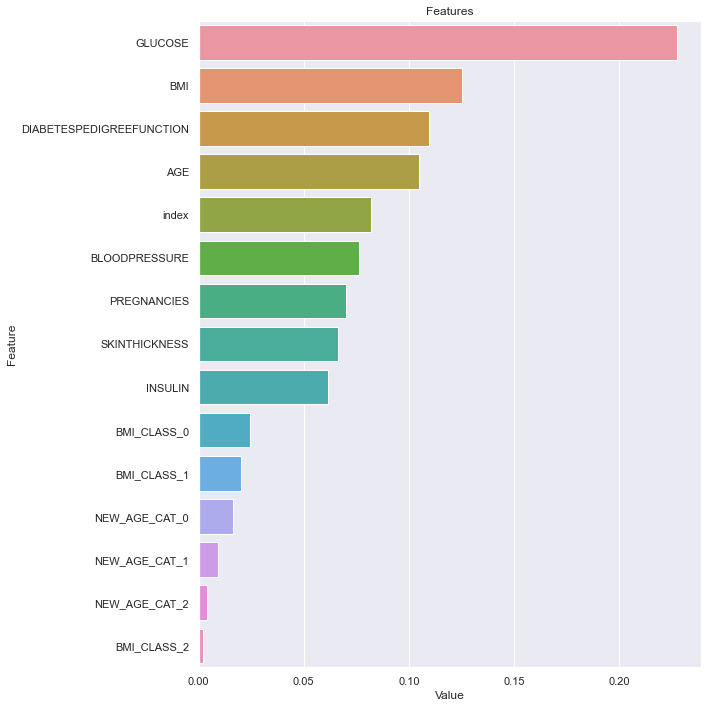

In [105]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importance.png")
plot_importance(rf_model, X_train)